In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from ht_sim_2 import sim1d

In [ ]:
# Geometry
length = 15.0e-3             # Length of the rod

# Material properties
rho = 2300.0                     # Density of AL380 (kg/m^3)
rho_l = 2460.0                   # Density of AL380 (kg/m^3)
rho_s = 2710.0                    # Density of AL380 (kg/m^3)
rho_m = (rho_l + rho_s )/2       # Desnity in mushy zone is taken as average of liquid and solid density

k = 104.0                       # W/m-K
k_l = k                       # W/m-K
k_s = 96.2                    # W/m-K
k_m =  (k_l+k_s)/2                     # W/m-K
k_mo = 41.5


cp = 1245.3                      # Specific heat of aluminum (J/kg-K)
cp_l = cp                      # Specific heat of aluminum (J/kg-K)
cp_s = 963.0                 # Specific heat of aluminum (J/kg-K)
cp_m =  (cp_l+cp_s)/2                 # Specific heat of mushy zone is taken as average of liquid and solid specific heat
# cp_m = cp
           # Thermal diffusivity
alpha_l = k_l / (rho_l * cp_l) 
alpha_s = k_s / (rho_s*cp_s)
alpha_m = k_m / (rho_m * cp_m)          #`Thermal diffusivity in mushy zone is taken as average of liquid and solid thermal diffusivity`


#L_fusion = 3.9e3                 # J/kg
L_fusion = 389.0e3               # J/kg  # Latent heat of fusion of aluminum
         # Thermal diffusivity


T_L = 847.4                       #  K -Liquidus Temperature (615 c) AL 380
T_S = 770.3                      # K- Solidus Temperature (550 C)
m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
print (f"alpha_l = {alpha_l}, alpha_s = {alpha_s}, m_eff = {m_eff}")

htc = -900.0                   # W/m^2-K
q = htc*(919.0-723.0)
# q = -1000.0


num_points = 50                        # Number of spatial points
dx = length / (num_points - 1)         # Distance between two spatial points
print('dx is',dx)
                                   #dt = time_end/num_steps
#num_steps = 200000               # Number of time steps
                                  # num_steps = round(time_end/dt)
                                                              
                            # Time Discretization  
# 

time_end = 1        # seconds                         
#num_steps = 10000
# dt = time_end/num_steps 
maxi = max(alpha_s,alpha_l,alpha_m)
dt = abs(0.5*((dx**2) /maxi))
current_time = dt

print('dt is ',dt)
num_steps = round(time_end/dt)+1
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/max(alpha_l,alpha_s,alpha_m))
print('cfl is',cfl)
#dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)
step_coeff = dt / (dx ** 2)
if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

In [ ]:
temp_init = 919.0
# Initial temperature and phase fields
temperature = np.full(num_points, temp_init)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
# temperature[-1] = 723.0 #(40 C)
phase[-1] = 1.0

# temperature[0] = 723.0 #(40 C)
phase[0] = 1.0


# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

t_surr = 573.0 # Surrounding temperature
dm = 60.0e-3   # thickness of the mold

r_m = k_mo / dm

midpoint_index = num_points // 2

midpoint_temperature_history = [temperature[midpoint_index]]

dm = 60.0e-3

r_m = k_mo / dm

t_surr = 573.0
# t_surr = h()

def kramp(temp,v1,v2,T_L,T_S):   # Function to calculate thermal conductivity in Mushy Zone
        slope = (v1-v2)/(T_L-T_S)
        if temp > T_L:
            k_m = k_l
        elif temp < T_S:
            k_m = k_s
        else:
            k_m = k_s + slope*(temp-T_S)
        return k_m

def cp_ramp(temp,v1,v2,T_L,T_s):    # Function to calculate specific heat capacity in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        cp_m = cp_l
    elif temp < T_S:
        cp_m = cp_s
    else:
        cp_m = cp_s + slope*(temp-T_S)
    return cp_m

def rho_ramp(temp,v1,v2,T_L,T_s):   # Function to calculate density in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        rho_m = rho_l
    elif temp < T_S:
        rho_m = rho_s
    else:
        rho_m = rho_s + slope*(temp-T_S)
    return rho_m

In [ ]:
while current_time < time_end:  # time loop
        r_s = k_s/dx
        temperature[0] = (r_s * temperature[1] + r_m * t_surr) / (r_s + r_m)
        temperature[-1] = (r_s * temperature[-2] + r_m * t_surr) / (r_s + r_m)                
        for n in range(1,num_points-1):              # space loop, adjusted range
                
            if temperature[n] >= T_L:

                temperature[n] = temperature[n] + ((alpha_l * step_coeff) * (temperature[n+1] - (2.0 * temperature[n]) + temperature[n-1]))
                
                phase[n] = 0
         
                
            elif T_S < temperature[n] < T_L:
            
                k_m = kramp(temperature[n],k_l,k_s,T_L,T_S)
                cp_m = cp_ramp(temperature[n],cp_l,cp_s,T_L,T_S)
                rho_m = rho_ramp(temperature[n],rho_l,rho_s,T_L,T_S)
                m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
                # r_s = k_m/dx

                temperature[n] = temperature[n] + ((m_eff * step_coeff)* (temperature[n+1] - (2.0 * temperature[n]) + temperature[n-1]))
                
                # temperature[0] = (r_s * temperature[1] + r_m * t_surr) / (r_s + r_m)
                # temperature[-1] = (r_s * temperature[-2] + r_m * t_surr) / (r_s + r_m)
                phase[n] = (T_L - temperature[n]) / (T_L - T_S) 
                
            
         
            elif temperature[n] <= T_S:
                temperature[n] = temperature[n] + ((alpha_s * step_coeff) * (temperature[n+1] - (2.0 * temperature[n])+ temperature[n-1]))
                r_s = k_s/dx
                # temperature[0] = (r_s * temperature[1] + r_m * t_surr) / (r_s + r_m)
                # temperature[-1] = (r_s * temperature[-2] + r_m * t_surr) / (r_s + r_m)
                phase[n] = 1
            
            else:
                print("ERROR: should not be here")
        
            
        current_time = current_time + dt
        time_end = time_end + dt
        temperature = temperature.copy()
        phase = phase.copy()
        temperature_history.append(temperature.copy())
        phi_history.append(phase.copy())
        midpoint_temperature_history.append(temperature[midpoint_index])        
        if np.all(phase == 1):
            print("Simulation complete @ time: ", current_time)
            break
        

In [ ]:
print(time_end)
temperature_history_1 = np.array(midpoint_temperature_history)
print(temperature_history_1.shape)
# Plot temperature history for debugging

time_ss= np.linspace(0, time_end, len(midpoint_temperature_history))
# print(time_ss.shape)
plt.figure(figsize=(10, 6))
plt.plot(time_ss, midpoint_temperature_history, label='Midpoint Temperature')
plt.axhline(y=T_L, color='r', linestyle='--', label='Liquidus Temperature')
plt.axhline(y=T_S, color='g', linestyle='--', label='Solidus Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution Over Time')
plt.legend()
plt.show()

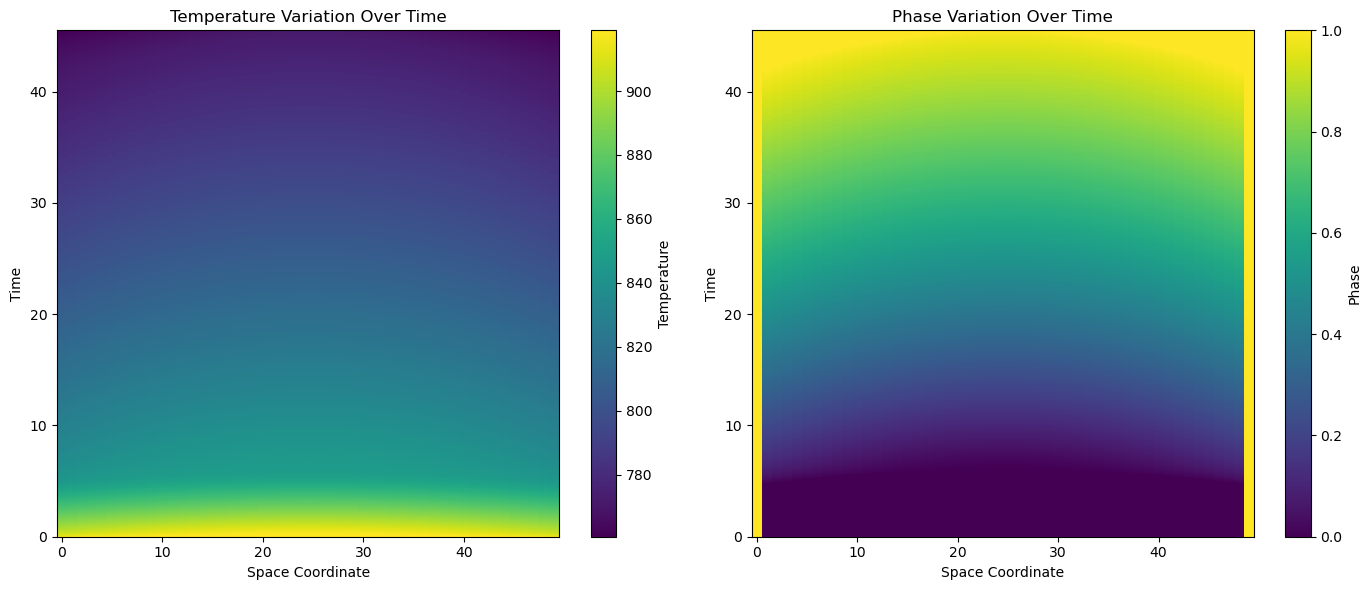

45.509313768600656


In [2]:
length = 15e-3
m = sim1d(rho_l=2460.0,rho_s=2710.0,k_l=104.0,k_s=96.2,cp_l=1245.3,cp_s=963.0,L_fusion=389.3e3,temp_init=919.0, t_surr=573.0)
print(m[0])